# Jonathan Halverson
# Monday, March 27, 2017
# Part 13: Simple predictive models

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')
from scipy.stats import binom, norm

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)

In [34]:
iofile = 'data/ufc_champions.csv'
champs = pd.read_csv(iofile, header=0, parse_dates=['Date'])
champs = champs.set_index('Name')
champs.head(3)

,Date
Name,
Amanda Nunes,2016-07-12
Anderson Silva,2006-10-17
Andrei Arlovski,2005-02-08


In [35]:
iofile = 'data/fightmetric_cards/fightmetric_fights_CLEAN_3-6-2017.csv'
fights = pd.read_csv(iofile, header=0, parse_dates=['Date'])
fights.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"


In [36]:
x = 'Anderson Silva'
fights[(fights.Winner == x) | (fights.Loser == x)]

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
306,Daniel Cormier,def.,Anderson Silva,Light Heavyweight,U-DEC,NaN,3,5:00,UFC 200: Tate vs Nunes,2016-07-09,"Las Vegas, Nevada, USA"
463,Michael Bisping,def.,Anderson Silva,Middleweight,U-DEC,NaN,5,5:00,UFC Fight Night: Silva vs Bisping,2016-02-27,"London, England, United Kingdom"
966,Anderson Silva,no contest,Nick Diaz,Middleweight,Overturned,NaN,5,5:00,UFC 183: Silva vs Diaz,2015-01-31,"Las Vegas, Nevada, USA"
1515,Chris Weidman,def.,Anderson Silva,Middleweight,KO/TKO,NaN,2,1:16,UFC 168: Weidman vs Silva 2,2013-12-28,"Las Vegas, Nevada, USA"
1714,Chris Weidman,def.,Anderson Silva,Middleweight,KO/TKO,Punch,2,1:18,UFC 162: Silva vs Weidman,2013-07-06,"Las Vegas, Nevada, USA"
1966,Anderson Silva,def.,Stephan Bonnar,Light Heavyweight,KO/TKO,Knee,1,4:40,UFC 153: Silva vs Bonnar,2012-10-13,"Rio de Janeiro, Brazil"
2053,Anderson Silva,def.,Chael Sonnen,Middleweight,KO/TKO,Punch,2,1:55,UFC 148: Silva vs Sonnen 2,2012-07-07,"Las Vegas, Nevada, USA"
2360,Anderson Silva,def.,Yushin Okami,Middleweight,KO/TKO,Punches,2,2:04,UFC 134: Silva vs Okami,2011-08-27,"Rio de Janeiro, Brazil"
2509,Anderson Silva,def.,Vitor Belfort,Middleweight,KO/TKO,Kick,1,3:25,UFC 126: Silva vs Belfort,2011-02-05,"Las Vegas, Nevada, USA"


We remove no contests immediately to avoid inf (infinity) in WinRatio, etc.:

In [37]:
fights = fights[fights.Outcome != 'no contest']
fights['Minutes'] = 5.0 * (fights.Round - 1) + fights.Time.apply(lambda x: int(x.split(':')[0]) + float(x.split(':')[1]) / 60.0)

In [38]:
# this assumes that the fights dataframe is ordered by date in descending order
# note that "no contests" are ignored which may not make sense for time_since
# for a fighter's first fight we assume they fought between 12-20 weeks ago
num_fights = []
num_fights_L = []
num_wins = []
num_wins_L = []
time_since = []
time_since_L = []
champ = []
champ_L = []
WTKO = []
WTKO_L = []
WSUB = []
WSUB_L = []
WDEC = []
WDEC_L = []
LTKO = []
LTKO_L = []
LSUB = []
LSUB_L = []
total_time = []
total_time_L = []
for index, row in fights.iterrows():
     d = row['Date']
     
     winner = row['Winner']
     x = fights[((fights.Winner == winner) | (fights.Loser == winner)) & (fights.Date < d)]
     # find time since last fight
     if (x.shape[0] > 0):
          weeks = (d - x.Date.sort_values(ascending=False).head(1).iloc[0]) / np.timedelta64(1, 'W')
          time_since.append(weeks)
          total_time.append(x.Minutes.sum())
     else:
          time_since.append(norm.rvs(loc=16.0, scale=5.0))
          total_time.append(0.0)
     num_fights.append(x.shape[0])
     # get number of wins and losses
     y = x[x.Winner == winner]
     l = x[x.Loser == winner]
     num_wins.append(y.shape[0])
     # compute wins by tko and sub
     if (y.shape[0] == 0):
          WTKO.append(0.0)
          WSUB.append(0.0)
          WDEC.append(0.0)
     else:
          WTKO.append(x[(x.Winner == winner) & x.Method.str.contains('KO')].shape[0] / float(y.shape[0]))
          WSUB.append(x[(x.Winner == winner) & x.Method.str.contains('SUB')].shape[0] / float(y.shape[0]))
          WDEC.append(x[(x.Winner == winner) & x.Method.str.contains('DEC|DQ')].shape[0] / float(y.shape[0]))
     if (l.shape[0] == 0):
          LTKO.append(0.0)
          LSUB.append(0.0)
     else:
          LTKO.append(x[(x.Loser == winner) & x.Method.str.contains('KO')].shape[0] / float(l.shape[0]))
          LSUB.append(x[(x.Loser == winner) & x.Method.str.contains('SUB')].shape[0] / float(l.shape[0]))
     # get champion status
     if (winner in champs.index):
          if (row['Date'] > champs.loc[winner].Date):
               champ.append(1)
          else:
               champ.append(0)
     else:
          champ.append(0)
     
     loser = row['Loser']
     x = fights[((fights.Winner == loser) | (fights.Loser == loser)) & (fights.Date < d)]
     # find time since last fight
     if (x.shape[0] > 0):
          weeks = (d - x.Date.sort_values(ascending=False).head(1).iloc[0]) / np.timedelta64(1, 'W')
          time_since_L.append(weeks)
          total_time_L.append(x.Minutes.sum())
     else:
          time_since_L.append(norm.rvs(loc=16.0, scale=5.0))
          total_time_L.append(0.0)
     num_fights_L.append(x.shape[0])
     # get number of wins
     y = x[x.Winner == loser]
     l = x[x.Loser == loser]
     num_wins_L.append(y.shape[0])
     # compute wins by tko and sub
     if (y.shape[0] == 0):
          WTKO_L.append(0.0)
          WSUB_L.append(0.0)
          WDEC_L.append(0.0)
     else:
          WTKO_L.append(x[(x.Winner == loser) & x.Method.str.contains('KO')].shape[0] / float(y.shape[0]))
          WSUB_L.append(x[(x.Winner == loser) & x.Method.str.contains('SUB')].shape[0] / float(y.shape[0]))
          WDEC_L.append(x[(x.Winner == loser) & x.Method.str.contains('DEC|DQ')].shape[0] / float(y.shape[0]))
     if (l.shape[0] == 0):
          LTKO_L.append(0.0)
          LSUB_L.append(0.0)
     else:
          LTKO_L.append(x[(x.Loser == loser) & x.Method.str.contains('KO')].shape[0] / float(l.shape[0]))
          LSUB_L.append(x[(x.Loser == loser) & x.Method.str.contains('SUB')].shape[0] / float(l.shape[0]))
     # get champion status
     if (loser in champs.index):
          if (row['Date'] > champs.loc[loser].Date):
               champ_L.append(1)
          else:
               champ_L.append(0)
     else:
          champ_L.append(0)
fights['NumFights'] = num_fights
fights['NumFights_L'] = num_fights_L
fights['NumWins'] = num_wins
fights['NumWins_L'] = num_wins_L
fights['WinRatio'] = fights.NumWins / fights.NumFights
fights['WinRatio_L'] = fights.NumWins_L / fights.NumFights_L
fights['TimeSince'] = time_since
fights['TimeSince_L'] = time_since_L
fights['Champ'] = champ
fights['Champ_L'] = champ_L
fights['WTKO'] = WTKO
fights['WTKO_L'] = WTKO_L
fights['WSUB'] = WSUB
fights['WSUB_L'] = WSUB_L
fights['LTKO'] = LTKO
fights['LTKO_L'] = LTKO_L
fights['LSUB'] = LSUB
fights['LSUB_L'] = LSUB_L
fights['WDEC'] = WDEC
fights['WDEC_L'] = WDEC_L
fights['total_time'] = total_time
fights['total_time_L'] = total_time_L

### Add fighter versitility index

In [39]:
fights['FVI'] = (3 / 2.0) * ((1 / 3.0) / (fights.WTKO**2 + fights.WSUB**2 + fights.WDEC**2) - (1 / 3.0))
fights['FVI_L'] = (3 / 2.0) * ((1 / 3.0) / (fights.WTKO_L**2 + fights.WSUB_L**2 + fights.WDEC_L**2) - (1 / 3.0))
fights.FVI = fights.FVI.replace([np.inf, -np.inf], np.nan)
fights.FVI_L = fights.FVI_L.replace([np.inf, -np.inf], np.nan)
fights.FVI = fights.FVI.fillna(0.0)
fights.FVI_L = fights.FVI_L.fillna(0.0)

### Replace null values

In [40]:
fights.WinRatio = fights.WinRatio.fillna(0.0)
fights.WinRatio_L = fights.WinRatio_L.fillna(0.0)

In [41]:
fights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4026 entries, 0 to 4067
Data columns (total 36 columns):
Winner          4026 non-null object
Outcome         4026 non-null object
Loser           4026 non-null object
WeightClass     4026 non-null object
Method          4026 non-null object
MethodNotes     2154 non-null object
Round           4026 non-null int64
Time            4026 non-null object
Event           4026 non-null object
Date            4026 non-null datetime64[ns]
Location        4026 non-null object
Minutes         4026 non-null float64
NumFights       4026 non-null int64
NumFights_L     4026 non-null int64
NumWins         4026 non-null int64
NumWins_L       4026 non-null int64
WinRatio        4026 non-null float64
WinRatio_L      4026 non-null float64
TimeSince       4026 non-null float64
TimeSince_L     4026 non-null float64
Champ           4026 non-null int64
Champ_L         4026 non-null int64
WTKO            4026 non-null float64
WTKO_L          4026 non-null float

In [42]:
fights.ix[:,10:].describe().applymap(lambda x: round(x, 2))

,Minutes,NumFights,NumFights_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L,WTKO,WTKO_L,WSUB,WSUB_L,LTKO,LTKO_L,LSUB,LSUB_L,WDEC,WDEC_L,total_time,total_time_L,FVI,FVI_L
count,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00,4026.00
mean,9.91,4.43,4.10,2.95,2.61,0.52,0.45,26.42,28.19,0.07,0.05,0.27,0.23,0.17,0.16,0.19,0.19,0.15,0.14,0.29,0.27,44.24,40.42,0.24,0.21
std,6.06,4.61,4.78,3.30,3.30,0.36,0.37,29.26,33.80,0.25,0.21,0.34,0.33,0.29,0.29,0.32,0.33,0.30,0.30,0.35,0.35,51.30,51.00,0.30,0.29
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.40,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4.07,1.00,1.00,0.00,0.00,0.00,0.00,15.14,15.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.72,1.28,0.00,0.00
50%,10.81,3.00,2.00,2.00,1.00,0.60,0.50,20.00,20.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.00,27.68,21.51,0.00,0.00
75%,15.00,7.00,6.00,4.00,4.00,0.79,0.75,28.11,29.00,0.00,0.00,0.50,0.50,0.25,0.25,0.33,0.33,0.00,0.00,0.50,0.50,63.74,57.87,0.48,0.41
max,25.00,26.00,26.00,19.00,19.00,1.00,1.00,597.14,581.14,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,362.82,337.82,1.30,1.00


### Correlation analysis

In [43]:
fights.ix[:,10:].corr().applymap(lambda x: round(x, 2))

,Minutes,NumFights,NumFights_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L,WTKO,WTKO_L,WSUB,WSUB_L,LTKO,LTKO_L,LSUB,LSUB_L,WDEC,WDEC_L,total_time,total_time_L,FVI,FVI_L
Minutes,1.00,0.13,0.09,0.15,0.10,0.10,0.14,0.00,0.02,0.15,0.05,-0.03,0.02,-0.02,0.05,-0.04,-0.04,0.01,-0.06,0.18,0.11,0.20,0.13,0.08,0.11
NumFights,0.13,1.00,0.43,0.96,0.44,0.40,0.30,0.06,0.06,0.34,0.17,0.28,0.22,0.17,0.09,0.27,0.11,0.15,0.07,0.28,0.17,0.94,0.41,0.66,0.34
NumFights_L,0.09,0.43,1.00,0.45,0.96,0.26,0.43,0.07,0.08,0.21,0.37,0.18,0.32,0.04,0.19,0.12,0.27,0.04,0.16,0.15,0.29,0.42,0.94,0.33,0.68
NumWins,0.15,0.96,0.45,1.00,0.47,0.51,0.34,0.02,0.07,0.42,0.21,0.29,0.23,0.16,0.10,0.23,0.10,0.10,0.06,0.29,0.18,0.90,0.43,0.69,0.36
NumWins_L,0.10,0.44,0.96,0.47,1.00,0.30,0.53,0.06,0.05,0.26,0.43,0.19,0.33,0.04,0.19,0.11,0.23,0.03,0.11,0.16,0.30,0.43,0.91,0.35,0.70
WinRatio,0.10,0.40,0.26,0.51,0.30,1.00,0.39,0.04,0.05,0.21,0.15,0.43,0.18,0.29,0.12,0.04,0.05,-0.01,0.03,0.46,0.21,0.36,0.25,0.45,0.25
WinRatio_L,0.14,0.30,0.43,0.34,0.53,0.39,1.00,0.02,0.04,0.19,0.19,0.16,0.46,0.11,0.33,0.06,0.06,0.05,0.04,0.22,0.49,0.29,0.40,0.30,0.48
TimeSince,0.00,0.06,0.07,0.02,0.06,0.04,0.02,1.00,0.03,0.06,0.05,0.05,0.02,0.05,-0.01,0.10,0.03,0.04,-0.01,0.04,0.03,0.05,0.06,0.03,0.04
TimeSince_L,0.02,0.06,0.08,0.07,0.05,0.05,0.04,0.03,1.00,0.06,0.06,0.05,0.03,0.01,0.06,0.02,0.11,0.04,0.07,0.01,0.02,0.06,0.05,0.05,0.03
Champ,0.15,0.34,0.21,0.42,0.26,0.21,0.19,0.06,0.06,1.00,0.23,0.15,0.13,0.01,0.02,0.12,0.06,0.01,-0.02,0.05,0.06,0.35,0.19,0.22,0.14


In [44]:
sorted(np.unique(np.abs(fights.ix[:,10:].corr().values.ravel())), reverse=True)[:10]

[1.0,
 0.96340532315631044,
 0.96062623016046,
 0.94063594884170509,
 0.93700232226430569,
 0.90802257208344794,
 0.90427150417147228,
 0.69810025539641241,
 0.68705320756965427,
 0.67693256073442754]

In [45]:
fights

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location,Minutes,NumFights,NumFights_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L,WTKO,WTKO_L,WSUB,WSUB_L,LTKO,LTKO_L,LSUB,LSUB_L,WDEC,WDEC_L,total_time,total_time_L,FVI,FVI_L
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",25.000000,4,5,3,3,0.750000,0.600000,39.857143,29.000000,0,1,0.666667,0.333333,0.000000,0.000000,1.000000,0.000000,0.000000,0.500000,0.333333,0.666667,29.733333,84.483333,0.400000,0.400000
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,20,9,16,7,0.800000,0.777778,31.000000,11.000000,1,0,0.687500,0.571429,0.187500,0.142857,0.500000,1.000000,0.000000,0.000000,0.125000,0.285714,194.650000,55.533333,0.455224,0.666667
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",3.683333,7,20,6,11,0.857143,0.550000,39.000000,13.000000,0,0,0.333333,0.545455,0.500000,0.000000,0.000000,0.444444,0.000000,0.333333,0.166667,0.454545,58.083333,187.816667,0.785714,0.491803
3,Glover Teixeira,def.,Jared Cannonier,Light Heavyweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,11,3,8,2,0.727273,0.666667,25.000000,10.000000,0,0,0.500000,0.500000,0.375000,0.000000,0.333333,1.000000,0.000000,0.000000,0.125000,0.500000,93.816667,20.683333,0.730769,0.500000
4,Dustin Poirier,def.,Jim Miller,Lightweight,M-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,16,24,12,17,0.750000,0.708333,21.000000,13.000000,0,0,0.416667,0.176471,0.250000,0.352941,0.500000,0.142857,0.250000,0.285714,0.333333,0.470588,128.500000,253.850000,0.940000,0.825688
5,Belal Muhammad,def.,Randy Brown,Welterweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,3,4,1,3,0.333333,0.750000,13.000000,9.142857,0,0,1.000000,0.333333,0.000000,0.333333,0.500000,0.000000,0.000000,1.000000,0.000000,0.333333,30.633333,39.233333,0.000000,1.000000
6,Wilson Reis,def.,Ulka Sasaki,Flyweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,7,4,5,2,0.714286,0.500000,28.000000,39.857143,0,0,0.000000,0.000000,0.400000,1.000000,0.000000,0.500000,0.000000,0.500000,0.600000,0.000000,80.283333,25.250000,0.461538,0.000000
7,Islam Makhachev,def.,Nik Lentz,Lightweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,3,16,2,11,0.666667,0.687500,21.000000,22.000000,0,0,0.000000,0.181818,0.500000,0.090909,1.000000,0.200000,0.000000,0.200000,0.500000,0.727273,24.400000,211.600000,0.500000,0.376812
8,Rick Glenn,def.,Phillipe Nover,Featherweight,S-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,1,6,0,1,0.000000,0.166667,21.000000,20.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,1.000000,15.000000,76.050000,0.000000,0.000000
9,Ryan LaFlare,def.,Roan Carneiro,Welterweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,6,8,5,4,0.833333,0.500000,61.142857,21.000000,0,0,0.000000,0.250000,0.000000,0.250000,0.000000,0.250000,0.000000,0.500000,1.000000,0.500000,100.000000,72.800000,0.000000,0.833333


In [46]:
x = 'Shane Carwin'
fights[(fights.Winner == x) | (fights.Loser == x)]

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location,Minutes,NumFights,NumFights_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L,WTKO,WTKO_L,WSUB,WSUB_L,LTKO,LTKO_L,LSUB,LSUB_L,WDEC,WDEC_L,total_time,total_time_L,FVI,FVI_L
2417,Junior Dos Santos,def.,Shane Carwin,Heavyweight,U-DEC,NaN,3,5:00,UFC 131: Dos Santos vs Carwin,2011-06-11,"Vancouver, British Columbia, Canada",15.000000,6,5,6,4,1.00,0.800000,44.00000,49.000000,0,1,0.833333,1.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.166667,0.000000,35.250000,14.516667,0.192308,0.000000
2658,Brock Lesnar,def.,Shane Carwin,Heavyweight,SUB,Arm Triangle,2,2:19,UFC 116: Lesnar vs Carwin,2010-07-03,"Las Vegas, Nevada, USA",7.316667,4,4,3,4,0.75,1.000000,51.00000,14.000000,1,1,0.666667,1.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.333333,0.000000,31.416667,7.200000,0.400000,0.000000
2734,Shane Carwin,def.,Frank Mir,Heavyweight,KO/TKO,Punches,1,3:48,UFC 111: St-Pierre vs Hardy,2010-03-27,"Newark, New Jersey, USA",3.800000,3,15,3,11,1.00,0.733333,55.00000,15.000000,0,1,1.000000,0.181818,0.0,0.636364,0.0,1.0,0.0,0.0,0.000000,0.181818,3.400000,58.300000,0.000000,0.561404
2961,Shane Carwin,def.,Gabriel Gonzaga,Heavyweight,KO/TKO,Punch,1,1:09,UFC 96: Jackson vs Jardine,2009-03-07,"Columbus, Ohio, USA",1.150000,2,8,2,6,1.00,0.750000,20.00000,16.000000,0,0,1.000000,0.666667,0.0,0.333333,0.0,1.0,0.0,0.0,0.000000,0.000000,2.250000,52.416667,0.000000,0.400000
3065,Shane Carwin,def.,Neil Wain,Heavyweight,KO/TKO,Punches,1,1:31,UFC 89: Bisping vs Leben,2008-10-18,"Birmingham, England, United Kingdom",1.516667,1,0,1,0,1.00,0.000000,21.00000,15.315767,0,0,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.733333,0.000000,0.000000,0.000000
3150,Shane Carwin,def.,Christian Wellisch,Heavyweight,KO/TKO,Punch,1,0:44,UFC 84: Ill Will,2008-05-24,"Las Vegas, Nevada, USA",0.733333,0,3,0,2,0.00,0.666667,4.71802,35.000000,0,0,0.000000,0.000000,0.0,0.500000,0.0,1.0,0.0,0.0,0.000000,0.500000,0.000000,21.166667,0.000000,0.500000


## Pull in more data sets

In [47]:
iofile = 'data/ufc_name_education.csv'
ufc = pd.read_csv(iofile, header=0)
ufc.head(3)

,Name,Education
0,Jim Alers,1
1,Corey Anderson,1
2,Rich Attonito,1


In [48]:
iofile = 'data/fightmetric_fighters_with_corrections_from_UFC_Wikipedia_CLEAN.csv'
fighters = pd.read_csv(iofile, header=0, parse_dates=['Dob'])
cols = ['Name', 'Height', 'Reach', 'LegReach', 'Stance', 'Dob']
df = fights.merge(fighters[cols], how='left', left_on='Winner', right_on='Name')
df = df.merge(fighters[cols], how='left', left_on='Loser', right_on='Name', suffixes=('', '_L'))
df = df.drop(['Name', 'Name_L'], axis=1)
df = df.merge(ufc, left_on='Winner', right_on='Name', how='left')
df = df.merge(ufc, left_on='Loser', right_on='Name', how='left', suffixes=('', '_L'))
df.Education = df.Education.fillna(0.0)
df.Education_L = df.Education_L.fillna(0.0)
df = df.drop(['Name', 'Name_L'], axis=1)
df.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location,Minutes,NumFights,NumFights_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L,WTKO,WTKO_L,WSUB,WSUB_L,LTKO,LTKO_L,LSUB,LSUB_L,WDEC,WDEC_L,total_time,total_time_L,FVI,FVI_L,Height,Reach,LegReach,Stance,Dob,Height_L,Reach_L,LegReach_L,Stance_L,Dob_L,Education,Education_L
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",25.000000,4,5,3,3,0.750000,0.600000,39.857143,29.0,0,1,0.666667,0.333333,0.0000,0.000000,1.0,0.000000,0.0,0.500000,0.333333,0.666667,29.733333,84.483333,0.400000,0.400000,69.0,71.0,41.0,Orthodox,1984-04-24,68.0,69.0,38.0,Southpaw,1981-10-17,0.0,0.0
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",15.000000,20,9,16,7,0.800000,0.777778,31.000000,11.0,1,0,0.687500,0.571429,0.1875,0.142857,0.5,1.000000,0.0,0.000000,0.125000,0.285714,194.650000,55.533333,0.455224,0.666667,74.0,77.0,42.0,Southpaw,1975-04-14,73.0,77.0,43.0,Southpaw,1984-01-04,0.0,1.0
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",3.683333,7,20,6,11,0.857143,0.550000,39.000000,13.0,0,0,0.333333,0.545455,0.5000,0.000000,0.0,0.444444,0.0,0.333333,0.166667,0.454545,58.083333,187.816667,0.785714,0.491803,73.0,72.0,41.0,Orthodox,1979-12-07,72.0,74.0,42.0,Orthodox,1981-01-28,0.0,1.0


In [49]:
iofile = 'data/fightmetric_career_stats.csv'
cstats = pd.read_csv(iofile, header=0)
cstats.head(3)

,Name,slpm,str_acc,sapm,str_def,td_avg,td_acc,td_def,sub_avg
0,Wesley Little,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1,Bryan Travers,2.33,0.48,3.93,0.55,2.00,0.28,0.63,0.0
2,Sean McCorkle,0.85,0.44,2.48,0.52,2.12,0.40,0.33,4.2


In [50]:
df = df.merge(cstats, left_on='Winner', right_on='Name', how='left')
df = df.merge(cstats, left_on='Loser', right_on='Name', how='left', suffixes=('', '_L'))

### More derived features

In [51]:
df['Age'] = (df.Date - df.Dob) / np.timedelta64(1, 'Y')
df['Age_L'] = (df.Date - df.Dob_L) / np.timedelta64(1, 'Y')
df['AccDamageAbsorbed'] = df.sapm * df.total_time
df['AccDamageAbsorbed_L'] = df.sapm_L * df.total_time_L
df['AllStrikesThrownPM'] = df.slpm / df.str_acc
df['AllStrikesThrownPM_L'] = df.slpm_L / df.str_acc_L
# note that the quantities below depend on both fighters
df['ExpectedStrikesAbsorbedPM'] = df.str_def * (df.slpm_L / df.str_acc_L)
df['ExpectedStrikesAbsorbedPM_L'] = df.str_def_L * (df.slpm / df.str_acc)
df['TkoSuscept'] = np.sqrt(df.LTKO * df.WTKO_L)
df['TkoSuscept_L'] = np.sqrt(df.LTKO_L * df.WTKO)
df['SubSuscept'] = np.sqrt(df.LSUB * df.WSUB_L)
df['SubSuscept_L'] = np.sqrt(df.LSUB_L * df.WSUB)

In [52]:
df.AllStrikesThrownPM = df.AllStrikesThrownPM.fillna(0.0)
df.AllStrikesThrownPM_L = df.AllStrikesThrownPM_L.fillna(0.0)

df.ExpectedStrikesAbsorbedPM = df.ExpectedStrikesAbsorbedPM.fillna(0.0)
df.ExpectedStrikesAbsorbedPM_L = df.ExpectedStrikesAbsorbedPM_L.fillna(0.0)

df.TkoSuscept = df.TkoSuscept.replace([np.inf, -np.inf], np.nan)
df.TkoSuscept_L = df.TkoSuscept_L.replace([np.inf, -np.inf], np.nan)
df.TkoSuscept = df.TkoSuscept.fillna(0.0)
df.TkoSuscept_L = df.TkoSuscept_L.fillna(0.0)

df.SubSuscept = df.SubSuscept.replace([np.inf, -np.inf], np.nan)
df.SubSuscept_L = df.SubSuscept_L.replace([np.inf, -np.inf], np.nan)
df.SubSuscept = df.SubSuscept.fillna(0.0)
df.SubSuscept_L = df.SubSuscept_L.fillna(0.0)

In [53]:
cols = ['Name', 'Name_L', 'WeightClass', 'Method', 'MethodNotes', 'Round', 'Time', 'Event', 'Location']
df = df.drop(cols, axis=1)

# Now inspect features

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4026 entries, 0 to 4025
Data columns (total 69 columns):
Winner                         4026 non-null object
Outcome                        4026 non-null object
Loser                          4026 non-null object
Date                           4026 non-null datetime64[ns]
Minutes                        4026 non-null float64
NumFights                      4026 non-null int64
NumFights_L                    4026 non-null int64
NumWins                        4026 non-null int64
NumWins_L                      4026 non-null int64
WinRatio                       4026 non-null float64
WinRatio_L                     4026 non-null float64
TimeSince                      4026 non-null float64
TimeSince_L                    4026 non-null float64
Champ                          4026 non-null int64
Champ_L                        4026 non-null int64
WTKO                           4026 non-null float64
WTKO_L                         4026 non-null float64


### Impute legreach using previously developed models

In [55]:
# see leg_reach_model.ipynb
def impute_legreach(x):
     if (pd.isnull(x.LegReach) and pd.notnull(x.Reach) and pd.notnull(x.Height)): 
          return 0.16095475 * x.Reach + 0.42165158 * x.Height - 0.901274878
     elif (pd.isnull(x.LegReach) and pd.notnull(x.Height)):
          return 0.59770 * x.Height - 1.69697
     else:
          return x.LegReach

In [56]:
def impute_legreach_L(x):
     if (pd.isnull(x.LegReach_L) and pd.notnull(x.Reach_L) and pd.notnull(x.Height_L)): 
          return 0.16095475 * x.Reach_L + 0.42165158 * x.Height_L - 0.901274878
     elif (pd.isnull(x.LegReach_L) and pd.notnull(x.Height_L)):
          return 0.59770 * x.Height_L - 1.69697
     else:
          return x.LegReach_L

In [57]:
df.LegReach = df.apply(impute_legreach, axis=1)
df.LegReach_L = df.apply(impute_legreach_L, axis=1)

In [58]:
def impute_reach(x):
     if (pd.isnull(x.Reach) and pd.notnull(x.Height)):
          return 1.093792 * x.Height - 4.94361
     else:
          return x.Reach

In [59]:
def impute_reach_L(x):
     if (pd.isnull(x.Reach_L) and pd.notnull(x.Height_L)):
          return 1.093792 * x.Height_L - 4.94361
     else:
          return x.Reach_L

In [60]:
df.Reach = df.apply(impute_reach, axis=1)
df.Reach_L = df.apply(impute_reach_L, axis=1)

In [61]:
df.describe()

,Minutes,NumFights,NumFights_L,NumWins,NumWins_L,WinRatio,WinRatio_L,TimeSince,TimeSince_L,Champ,Champ_L,WTKO,WTKO_L,WSUB,WSUB_L,LTKO,LTKO_L,LSUB,LSUB_L,WDEC,WDEC_L,total_time,total_time_L,FVI,FVI_L,Height,Reach,LegReach,Height_L,Reach_L,LegReach_L,Education,Education_L,slpm,str_acc,sapm,str_def,td_avg,td_acc,td_def,sub_avg,slpm_L,str_acc_L,sapm_L,str_def_L,td_avg_L,td_acc_L,td_def_L,sub_avg_L,Age,Age_L,AccDamageAbsorbed,AccDamageAbsorbed_L,AllStrikesThrownPM,AllStrikesThrownPM_L,ExpectedStrikesAbsorbedPM,ExpectedStrikesAbsorbedPM_L,TkoSuscept,TkoSuscept_L,SubSuscept,SubSuscept_L
count,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4022.000000,4022.000000,4022.000000,4006.000000,4006.000000,4006.000000,4026.000000,4026.000000,4026.000000,4026.00000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,3970.000000,3873.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000
mean,9.907365,4.426478,4.103577,2.954049,2.608793,0.517829,0.452746,26.416756,28.190945,0.068554,0.048187,0.265376,0.232536,0.170557,0.157976,0.185856,0.191176,0.150283,0.140623,0.291260,0.268901,44.236620,40.424942,0.238713,0.205355,70.850075,72.691365,40.610649,70.744633,72.422245,40.569346,0.193741,0.154496,2.986143,0.42584,2.688949,0.557211,1.771659,0.412049,0.592854,0.796249,2.572735,0.398433,2.994449,0.516413,1.471985,0.353932,0.511975,0.745777,29.245781,29.930146,117.486833,114.772522,6.926229,6.242774,3.613163,3.746929,0.087952,0.099281,0.046815,0.047575
std,6.060105,4.612937,4.784857,3.301741,3.299571,0.362820,0.368265,29.264685,33.802605,0.252726,0.214187,0.340462,0.331814,0.289458,0.287870,0.324651,0.333541,0.304617,0.296502,0.345626,0.349656,51.302106,51.001215,0.297218,0.286118,3.293358,3.910980,2.241040,3.229613,3.769126,2.096496,0.395277,0.361468,1.204605,0.10599,1.055189,0.123255,1.350937,0.202189,0.226707,0.873160,1.243973,0.131652,1.531252,0.149305,1.296993,0.238102,0.263350,0.983488,3.971142,4.124815,139.323599,146.375345,2.817784,3.028171,1.880475,1.820768,0.217522,0.232290,0.163300,0.161286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.400475,0.312913,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,60.000000,32.000000,60.000000,60.000000,32.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.589725,18.267316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.070833,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,15.142857,15.047938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.716667,1.283333,0.000000,0.000000,69.000000,70.000000,39.000000,69.000000,70.000000,39.000000,0.000000,0.000000,2.230000,0.38000,2.070000,0.520000,0.740000,0.310000,0.500000,0.200000,1.830000,0.350000,2.220000,0.480000,0.460000,0.200000,0.360000,0.000000,26.380418,26.935529,12.082125,0.000000,5.196341,4.502907,2.458339,2.620089,0.000000,0.000000,0.000000,0.000000
50%,10.808333,3.000000,2.000000,2.000000,1.000000,0.600000,0.500000,20.000000,20.169411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,27.683333,21.508333,0.000000,0.000000,71.000000,73.000000,41.000000,71.000000,72.715622,40.739730,0.000000,0.000000,2.960000,0.43000,2.650000,0.580000,1.530000,0.410000,0.630000,0.600000,2.620000,0.410000,2.835000,0.550000,1.25

In [62]:
#df = df.dropna()

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4026 entries, 0 to 4025
Data columns (total 69 columns):
Winner                         4026 non-null object
Outcome                        4026 non-null object
Loser                          4026 non-null object
Date                           4026 non-null datetime64[ns]
Minutes                        4026 non-null float64
NumFights                      4026 non-null int64
NumFights_L                    4026 non-null int64
NumWins                        4026 non-null int64
NumWins_L                      4026 non-null int64
WinRatio                       4026 non-null float64
WinRatio_L                     4026 non-null float64
TimeSince                      4026 non-null float64
TimeSince_L                    4026 non-null float64
Champ                          4026 non-null int64
Champ_L                        4026 non-null int64
WTKO                           4026 non-null float64
WTKO_L                         4026 non-null float64


Filter fights to defeats since January 1, 2005:

In [64]:
fs = df[(df.Date > pd.to_datetime('2005-01-01')) & (df.Outcome == 'def.')].copy()
fs.shape[0]

3561

# Compute accuracy using simple rules

### Younger wins

In [65]:
yw = fs[pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L) & (fs.Dob != fs.Dob_L)]
wins = yw[yw.Dob > yw.Dob_L].shape[0]
total = yw.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

(1964, 3529, 0.5565315953527912, 32, 1.9906913544237038e-11)

### Longer reach wins

In [ ]:
lr = fs[pd.notnull(fs.Reach) & pd.notnull(fs.Reach_L) & (fs.Reach != fs.Reach_L)]
wins = lr[lr.Reach > lr.Reach_L].shape[0]
total = lr.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

What if we don't exclude nulls?

In [ ]:
lr = fs[fs.Reach != fs.Reach_L]
wins = lr[lr.Reach > lr.Reach_L].shape[0]
total = lr.shape[0]
wins, total, wins / float(total), fs.shape[0] - total

In [ ]:
71.0 > np.nan

In [ ]:
71.0 == np.nan

In [ ]:
lr[['Reach', 'Reach_L']].info()

We see that nulls in Reach_L lead to Falses which increased the total which gave a win ratio less than 1/2.

### Taller wins

In [ ]:
ht = fs[pd.notnull(fs.Height) & pd.notnull(fs.Height_L) & (fs.Height != fs.Height_L)]
wins = ht[ht.Height > ht.Height_L].shape[0]
total = ht.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

### Stance

In [ ]:
st = fs[pd.notnull(fs.Stance) & pd.notnull(fs.Stance_L) & (((fs.Stance == 'Orthodox') & (fs.Stance_L == 'Southpaw')) | ((fs.Stance == 'Southpaw') & (fs.Stance_L == 'Orthodox')))]
wins = st[st.Stance == 'Southpaw'].shape[0]
total = st.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

### Education

In [ ]:
ed = fs[pd.notnull(fs.Education) & pd.notnull(fs.Education_L) & (fs.Education != fs.Education_L)]
wins = ed[ed.Education == 1].shape[0]
total = ed.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

### Leg reach

In [ ]:
lg = fs[pd.notnull(fs.LegReach) & pd.notnull(fs.LegReach_L) & (fs.LegReach != fs.LegReach_L)]
wins = lg[lg.LegReach > lg.LegReach_L].shape[0]
total = lg.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

### Predict winner has more UFC fights

In [ ]:
nf = fs[pd.notnull(fs.Num) & pd.notnull(fs.Num_L) & (fs.Num != fs.Num_L)]
wins = nf[nf.Num > nf.Num_L].shape[0]
total = nf.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

### Predict winner has higher win ratio (for 5 fights or more)

In [ ]:
wr = fs[pd.notnull(fs.WinRatio) & pd.notnull(fs.WinRatio_L) & (fs.WinRatio != fs.WinRatio_L) & (fs.Num > 4) & (fs.Num_L > 4)]
wins = wr[wr.WinRatio > wr.WinRatio_L].shape[0]
total = wr.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

In [ ]:
# How does the result change if we replace NaN with 0.5 and don't require a certain number of fights?
# Ans: (1571, 2728, 0.5758797653958945, 833, 2.331962646952389e-15)
#fs.WinRatio = fs.WinRatio.fillna(0.5)
#fs.WinRatio_L = fs.WinRatio_L.fillna(0.5)

### Fighter who fought more recently wins

In [ ]:
vd = fs[pd.notnull(fs.TimeSince) & pd.notnull(fs.TimeSince_L) & (fs.TimeSince != fs.TimeSince_L)]

wins = vd[vd.TimeSince < vd.TimeSince_L].shape[0]
total = vd.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

### Current or former champion wins

In [ ]:
vd = fs[pd.notnull(fs.Champ) & pd.notnull(fs.Champ_L) & (fs.Champ != fs.Champ_L)]

wins = vd[vd.Champ == 1].shape[0]
total = vd.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

### Higher win ratio and younger

In [ ]:
vd = fs[pd.notnull(fs.WinRatio) & pd.notnull(fs.WinRatio_L) & pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L) & (fs.WinRatio != fs.WinRatio_L) & (fs.Dob != fs.Dob_L) & (fs.Num > 4) & (fs.Num_L > 4)]
msk1 = (vd.WinRatio > vd.WinRatio_L) & (vd.Dob > vd.Dob_L)
msk2 = (vd.WinRatio < vd.WinRatio_L) & (vd.Dob < vd.Dob_L)

sp = vd[msk1 | msk2]
wins = sp[sp.WinRatio > sp.WinRatio_L].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

### Reach advantage of 4 inches or more

In [ ]:
vd = fs[pd.notnull(fs.Reach) & pd.notnull(fs.Reach_L)]
msk1 = np.abs(vd.Reach - vd.Reach_L) >= 4

sp = vd[msk1]
wins = sp[(sp.Reach > sp.Reach_L)].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

In [ ]:
sp[['Winner', 'Reach', 'Loser', 'Reach_L']].head(10)

### 4 years or more younger

In [ ]:
vd = fs[pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L)]
msk1 = ((vd.Dob - vd.Dob_L) / np.timedelta64(1, 'Y'))**2 >= 16

sp = vd[msk1]
wins = sp[(sp.Dob > sp.Dob_L)].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

In [ ]:
sp[['Winner', 'Dob', 'Loser', 'Dob_L']].head(20)

### Younger and greater reach

In [ ]:
vd = fs[pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L) & pd.notnull(fs.Reach) & pd.notnull(fs.Reach_L)]
msk1 = (vd.Reach > vd.Reach_L) & (vd.Dob > vd.Dob_L)
msk2 = (vd.Reach < vd.Reach_L) & (vd.Dob < vd.Dob_L)

sp = vd[msk1 | msk2]
wins = sp[(sp.Dob > sp.Dob_L) & (sp.Reach > sp.Reach_L)].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

### Southpaw and younger

In [ ]:
vd = fs[pd.notnull(fs.Stance) & pd.notnull(fs.Stance_L) & pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L)]
msk1 = (vd.Stance == 'Southpaw') & (vd.Stance_L == 'Orthodox') & (vd.Dob > vd.Dob_L)
msk2 = (vd.Stance == 'Orthodox') & (vd.Stance_L == 'Southpaw') & (vd.Dob < vd.Dob_L)

sp = vd[msk1 | msk2]
wins = sp[sp.Stance == 'Southpaw'].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

### South, younger and greater reach

In [ ]:
vd = fs[pd.notnull(fs.Stance) & pd.notnull(fs.Stance_L) & pd.notnull(fs.Dob) & pd.notnull(fs.Dob_L) & pd.notnull(fs.Reach) & pd.notnull(fs.Reach_L)]
msk1 = (vd.Stance == 'Southpaw') & (vd.Stance_L == 'Orthodox') & (vd.Reach > vd.Reach_L) & (vd.Dob > vd.Dob_L)
msk2 = (vd.Stance == 'Orthodox') & (vd.Stance_L == 'Southpaw') & (vd.Reach < vd.Reach_L) & (vd.Dob < vd.Dob_L)

sp = vd[msk1 | msk2]
wins = sp[sp.Stance == 'Southpaw'].shape[0]
total = sp.shape[0]
wins, total, wins / float(total), fs.shape[0] - total, 2 * binom.cdf(p=0.5, k=min(wins, total - wins), n=total)

In [ ]:
sp[['Winner', 'Dob', 'Reach', 'Stance', 'Loser', 'Dob_L', 'Reach_L', 'Stance_L']].head()

### Overall win ratio

In [ ]:
fs_fighters = fs.Winner.append(fs.Loser).value_counts().to_frame()
wins = fs.Winner.value_counts().to_frame()
loses = fs.Loser.value_counts().to_frame()
fs_fighters = fs_fighters.merge(wins, left_index=True, right_index=True, how='left')
fs_fighters = fs_fighters.merge(loses, left_index=True, right_index=True, how='left')
fs_fighters = fs_fighters.fillna(0.0)
fs_fighters.columns = ['Total', 'Wins', 'Losses']
fs_fighters['WinRatio'] = fs_fighters.Wins / (fs_fighters.Wins + fs_fighters.Losses)

In [ ]:
ws = fs.merge(fs_fighters[['Total', 'WinRatio']], left_on='Winner', right_index=True, how='left')
ws = ws.merge(fs_fighters[['Total', 'WinRatio']], left_on='Loser', right_index=True, how='left', suffixes=('', '_L'))
ws.head(3)

In [ ]:
ws = ws[pd.notnull(ws.WinRatio) & pd.notnull(ws.WinRatio_L) & (ws.Total > 5) & (ws.Total_L > 5)]
wins = ws[ws.WinRatio > ws.WinRatio_L].shape[0]
total = ws.shape[0]
wins, total, wins / float(total), ws.shape[0] - total

# Part II: Cleaning, imputing and standardizing

In [67]:
fs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3561 entries, 0 to 3580
Data columns (total 69 columns):
Winner                         3561 non-null object
Outcome                        3561 non-null object
Loser                          3561 non-null object
Date                           3561 non-null datetime64[ns]
Minutes                        3561 non-null float64
NumFights                      3561 non-null int64
NumFights_L                    3561 non-null int64
NumWins                        3561 non-null int64
NumWins_L                      3561 non-null int64
WinRatio                       3561 non-null float64
WinRatio_L                     3561 non-null float64
TimeSince                      3561 non-null float64
TimeSince_L                    3561 non-null float64
Champ                          3561 non-null int64
Champ_L                        3561 non-null int64
WTKO                           3561 non-null float64
WTKO_L                         3561 non-null float64


### Replace stance with numerical values (ordinal)

In [68]:
fs.Stance.value_counts()

Orthodox       2620
Southpaw        751
Switch           70
Open Stance      13
Name: Stance, dtype: int64

In [69]:
fs.Stance_L.value_counts()

Orthodox       2704
Southpaw        636
Switch           79
Open Stance       9
Sideways          1
Name: Stance_L, dtype: int64

In [70]:
gs = fs[fs.Stance.isin(['Southpaw', 'Orthodox', 'Switch']) & fs.Stance_L.isin(['Southpaw', 'Orthodox', 'Switch'])].copy()

In [71]:
gs.Stance = gs.Stance.replace({'Switch':0}).replace({'Southpaw':1, 'Orthodox':-1})
gs.Stance_L = gs.Stance_L.replace({'Switch':0}).replace({'Southpaw':1, 'Orthodox':-1})

gs['AgeDiff'] = gs.Age - gs.Age_L
gs['ReachDiff'] = gs.Reach - gs.Reach_L
gs['StanceDiff'] = gs.Stance - gs.Stance_L
gs['EducationDiff'] = gs.Education - gs.Education_L
gs['WinRatioDiff'] = gs.WinRatio - gs.WinRatio_L
gs['NumFightsDiff'] = gs.Num - gs.Num_L
gs['TimeSinceDiff'] = gs.TimeSince - gs.TimeSince_L
gs['ChampDiff'] = gs.Champ - gs.Champ_L
gs['SApMDiff'] = gs.sapm - gs.sapm_L
gs['SLpMDiff'] = gs.slpm - gs.slpm_L
gs['TDavgDiff'] = gs.td_avg - gs.td_avg_L
gs['TDdefDiff'] = gs.td_def - gs.td_def_L
gs['SubavgDiff'] = gs.sub_avg - gs.sub_avg_L
gs['FVIDiff'] = gs.FVI - gs.FVI_L
gs['FVIDiff'] = gs.WTKO * gs.LTKO_L - gs.FVI_L
gs = gs[['AgeDiff', 'ReachDiff', 'StanceDiff', 'EducationDiff', 'WinRatioDiff', 'NumFightsDiff', 'TimeSinceDiff', 'ChampDiff', 'SApMDiff', 'SLpMDiff', 'TDavgDiff', 'TDdefDiff', 'SubavgDiff', 'FVIDiff']]
gs.info()

In [98]:
cols = set(gs.columns)
cols = cols - set(['Winner', 'Loser', 'Outcome', 'Date', 'Minutes', 'Dob', 'Dob_L'])
cols = list(cols)
win_cols = sorted(filter(lambda x: not x.endswith('_L'), cols))
los_cols = sorted(filter(lambda x: x.endswith('_L'), cols))
gs = gs[win_cols + los_cols]
gs.shape

(3329, 62)

In [90]:
gs.describe()

,AccDamageAbsorbed,Age,AllStrikesThrownPM,Champ,Education,ExpectedStrikesAbsorbedPM,FVI,Height,LSUB,LTKO,LegReach,NumFights,NumWins,Reach,Stance,SubSuscept,TimeSince,TkoSuscept,WDEC,WSUB,WTKO,WinRatio,sapm,slpm,str_acc,str_def,sub_avg,td_acc,td_avg,td_def,total_time,AccDamageAbsorbed_L,Age_L,AllStrikesThrownPM_L,Champ_L,Education_L,ExpectedStrikesAbsorbedPM_L,FVI_L,Height_L,LSUB_L,LTKO_L,LegReach_L,NumFights_L,NumWins_L,Reach_L,Stance_L,SubSuscept_L,TimeSince_L,TkoSuscept_L,WDEC_L,WSUB_L,WTKO_L,WinRatio_L,sapm_L,slpm_L,str_acc_L,str_def_L,sub_avg_L,td_acc_L,td_avg_L,td_def_L,total_time_L
count,3329.000000,3327.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3302.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000
mean,131.544153,29.349058,7.296975,0.069390,0.212376,3.901744,0.261262,70.783719,0.150372,0.194402,40.571831,4.842896,3.222890,72.641821,-0.541003,0.048455,26.739648,0.095455,0.314942,0.173628,0.272619,0.537058,2.782124,3.139294,0.436482,0.579438,0.817212,0.423082,1.851832,0.621667,49.296711,129.321633,30.091420,6.700065,0.049865,0.173926,4.028384,0.229180,70.676780,0.145860,0.205659,40.518557,4.551817,2.886452,72.353559,-0.609192,0.050382,28.119280,0.107172,0.290431,0.165880,0.242497,0.473802,3.153307,2.759883,0.418303,0.547798,0.770111,0.374476,1.573433,0.546675,45.405122
std,144.294663,3.935948,2.481713,0.254155,0.409051,1.691637,0.303991,3.297101,0.297818,0.325376,2.279051,4.772493,3.424434,3.947150,0.829275,0.160793,30.244678,0.221988,0.345089,0.285071,0.336708,0.349733,0.920834,1.061279,0.075863,0.073464,0.862957,0.184880,1.327316,0.198497,53.201501,152.095100,4.068461,2.682826,0.217698,0.379103,1.599038,0.294813,3.176036,0.295353,0.338521,2.093383,4.965364,3.433918,3.722046,0.778806,0.161695,33.591276,0.236429,0.349486,0.287912,0.329522,0.356936,1.391213,1.095371,0.094977,0.091782,0.927131,0.224374,1.280907,0.238442,53.065811
min,0.000000,19.589725,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,0.000000,32.000000,0.000000,0.000000,60.000000,-1.000000,0.000000,-0.400475,0.000000,0.000000,0.000000,0.000000,0.000000,0.170000,0.000000,0.000000,0.260000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.541106,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,0.000000,32.000000,0.000000,0.000000,60.000000,-1.000000,0.000000,0.312913,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.100000,26.533057,5.588235,0.000000,0.000000,2.734286,0.000000,69.000000,0.000000,0.000000,39.000000,1.000000,1.000000,70.000000,-1.000000,0.000000,15.857143,0.000000,0.000000,0.000000,0.000000,0.250000,2.170000,2.370000,0.390000,0.540000,0.300000,0.330000,0.840000,0.530000,11.266667,14.160000,27.177149,4.962264,0.000000,0.000000,2.922128,0.000000,69.000000,0.000000,0.000000,39.000000,1.000000,0.000000,70.000000,-1.000000,0.000000,15.261478,0.000000,0.000000,0.000000,0.000000,0.000000,2.330000,2.030000,0.360000,0.500000,0.100000,0.250000,0.620000,0.400000,4.550000
50%,86.271000,29.169661,7.000000,0.000000,0.000000,3.706757,0.000000,71.000000,0.000000,0.000000,40.946639,3.000000,2.000000,73.000000,-1.000000,0.000000,20.571429,0.000000,0.250000,0.000000,0.090909,0.615385,2.710000,3.100000,0.430000,0.590000,0.600000,0.420000,1.620000,0.640000,31.916667,76.775500,29.885624,6.400000,0.000000,0.000000,3.824000,0.00000

In [ ]:
gs.corr().applymap(lambda x: abs(round(x, 2)))

In [99]:
shuffled = []
from random import random as rng
for index, row in gs.iterrows():
     if (rng() < 0.5):
          shuffled.append(([1] + list(row[31:].values) + list(row[:31].values)))
          #shuffled.append(([1] + list(-1 * row.values)))
     else:
          shuffled.append(([0] + list(row.values)))

In [100]:
data = pd.DataFrame(shuffled)
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
count,3329.000000,3329.000000,3313.000000,3329.000000,3329.000000,3329.00000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3316.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.00000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000,3329.000000
mean,0.508561,130.059525,29.677988,7.010193,0.063382,0.19976,3.955071,0.247211,70.735957,0.150088,0.199586,40.552715,4.668970,3.033343,72.526066,-0.613097,0.050859,27.546291,0.102743,0.298977,0.171938,0.253794,0.499317,2.984410,2.953298,0.427047,0.562625,0.793031,0.399057,1.682001,0.587263,47.042075,130.806261,29.759653,6.986848,0.055873,0.186543,3.975057,0.243232,70.724542,0.146143,0.200475,40.537673,4.725743,3.075999,72.469314,-0.537098,0.047978,27.312637,0.099885,0.306397,0.16757,0.261322,0.511542,2.951021,2.945879,0.427738,0.564611,0.794293,0.398501,1.743265,0.581078,47.659758
std,0.500002,146.310006,3.958623,2.608975,0.243686,0.39988,1.646095,0.299278,3.270410,0.298000,0.332363,2.206667,4.817935,3.413302,3.865811,0.777089,0.165079,31.861920,0.232773,0.344316,0.286536,0.330610,0.354017,1.234265,1.096367,0.088154,0.084236,0.898459,0.206826,1.268301,0.221850,52.364432,150.164719,4.079365,2.593768,0.229710,0.389602,1.648258,0.300440,3.204395,0.295174,0.331758,2.169851,4.925424,3.453058,3.811702,0.830545,0.157309,32.075803,0.225961,0.350637,0.28649,0.336273,0.355408,1.152540,1.093665,0.084674,0.084993,0.893390,0.207191,1.353067,0.223230,53.960448
min,0.000000,0.000000,19.775902,0.000000,0.000000,0.00000,0.000000,0.000000,60.000000,0.000000,0.000000,32.000000,0.000000,0.000000,60.000000,-1.000000,0.000000,-0.400475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.541106,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,0.000000,32.000000,0.000000,0.000000,60.000000,-1.000000,0.000000,0.312913,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.928000,26.746614,5.220000,0.000000,0.00000,2.812000,0.000000,69.000000,0.000000,0.000000,39.000000,1.000000,0.000000,70.000000,-1.000000,0.000000,15.362893,0.000000,0.000000,0.000000,0.000000,0.000000,2.270000,2.180000,0.380000,0.520000,0.200000,0.290000,0.720000,0.470000,7.166667,20.119500,26.959486,5.200000,0.000000,0.000000,2.851351,0.000000,69.000000,0.000000,0.000000,39.000000,1.000000,0.000000,70.000000,-1.000000,0.000000,15.571429,0.000000,0.000000,0.00000,0.000000,0.000000,2.240000,2.190000,0.370000,0.520000,0.200000,0.300000,0.730000,0.470000,7.666667
50%,1.000000,83.958333,29.500948,6.693878,0.000000,0.00000,3.750000,0.000000,71.000000,0.000000,0.000000,40.785684,3.000000,2.000000,73.000000,-1.000000,0.000000,20.428571,0.000000,0.200000,0.000000,0.000000,0.571429,2.800000,2.890000,0.420000,0.570000,0.600000,0.400000,1.440000,0.620000,30.116667,78.882500,29.543386,6.731343,0.000000,0.000000,3.787755,0.000000,71.000000,0.000000,0.000000,40.624729,3.000000,2.000000,73.000000,-1.000000,0.000000,20.784808,0.000000,0.200000,0.00000,0.000000,0.583333,2.790000,2.870000,0.420000,0.570000,0.600000,0.400000,1.520000,0.610000,30.000000
75%,1.000000,188.576667,32.241593,8.590909,0.000000,0.00000,4.906667,0.496552,73.000000,0.142857,0.333333,42.000000,7.000000,5.000000,75.000000,-1.

In [101]:
sorted(data.corr().applymap(lambda x: abs(round(x, 2))).values.flatten().tolist(), reverse=True)[:15]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [102]:
cols = [0, 1, 3, 7, 8, 10, 14]
cols = [0, 7, 14]
#cols = [0, 3, 10]
cols = range(data.shape[1])
data = data.loc[:,cols].dropna()
data = data.sample(data.shape[0], replace=False, axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3300 entries, 2090 to 1161
Data columns (total 63 columns):
0     3300 non-null int64
1     3300 non-null float64
2     3300 non-null float64
3     3300 non-null float64
4     3300 non-null float64
5     3300 non-null float64
6     3300 non-null float64
7     3300 non-null float64
8     3300 non-null float64
9     3300 non-null float64
10    3300 non-null float64
11    3300 non-null float64
12    3300 non-null float64
13    3300 non-null float64
14    3300 non-null float64
15    3300 non-null float64
16    3300 non-null float64
17    3300 non-null float64
18    3300 non-null float64
19    3300 non-null float64
20    3300 non-null float64
21    3300 non-null float64
22    3300 non-null float64
23    3300 non-null float64
24    3300 non-null float64
25    3300 non-null float64
26    3300 non-null float64
27    3300 non-null float64
28    3300 non-null float64
29    3300 non-null float64
30    3300 non-null float64
31    3300 non-null floa

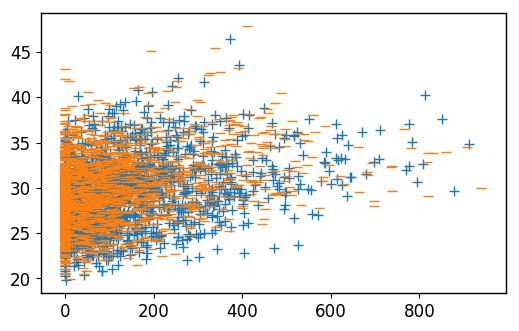

In [103]:
plt.scatter(data[data.loc[:,0]==0].iloc[:,1], data[data.loc[:,0]==0].iloc[:,2], marker='+')
plt.scatter(data[data.loc[:,0]==1].iloc[:,1], data[data.loc[:,0]==1].iloc[:,2], marker='_')

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

### Binary decision trees

In [105]:
from sklearn.tree import DecisionTreeClassifier
# different scoring metrics: http://scikit-learn.org/stable/modules/model_evaluation.html

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(max_depth=range(1, 10), criterion=['gini', 'entropy'], splitter=['best', 'random'])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = DecisionTreeClassifier(random_state=0)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     y_test_prob = grid.predict_proba(X_test)[:,1]
     test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy, metrics.brier_score_loss(y_test, y_test_prob)

0 0.623376623377 {'splitter': 'best', 'criterion': 'entropy', 'max_depth': 7} 0.610101010101 0.478586711392
1 0.602164502165 {'splitter': 'best', 'criterion': 'gini', 'max_depth': 4} 0.581818181818 0.401114989997
2 0.636363636364 {'splitter': 'best', 'criterion': 'entropy', 'max_depth': 6} 0.6 0.415289297227
3 0.609956709957 {'splitter': 'best', 'criterion': 'gini', 'max_depth': 6} 0.626262626263 0.282748198139
4 0.606060606061 {'splitter': 'best', 'criterion': 'gini', 'max_depth': 4} 0.590909090909 0.258192881118
5 0.62380952381 {'splitter': 'best', 'criterion': 'entropy', 'max_depth': 5} 0.60404040404 0.252452878273
6 0.619913419913 {'splitter': 'best', 'criterion': 'gini', 'max_depth': 4} 0.587878787879 0.311635505362
7 0.630735930736 {'splitter': 'best', 'criterion': 'gini', 'max_depth': 3} 0.589898989899 0.251568461676
8 0.619047619048 {'splitter': 'best', 'criterion': 'gini', 'max_depth': 4} 0.59696969697 0.325072358601
9 0.606060606061 {'splitter': 'best', 'criterion': 'gini', '

In [106]:
np.array(test_accuracies).mean()

0.60232323232323226

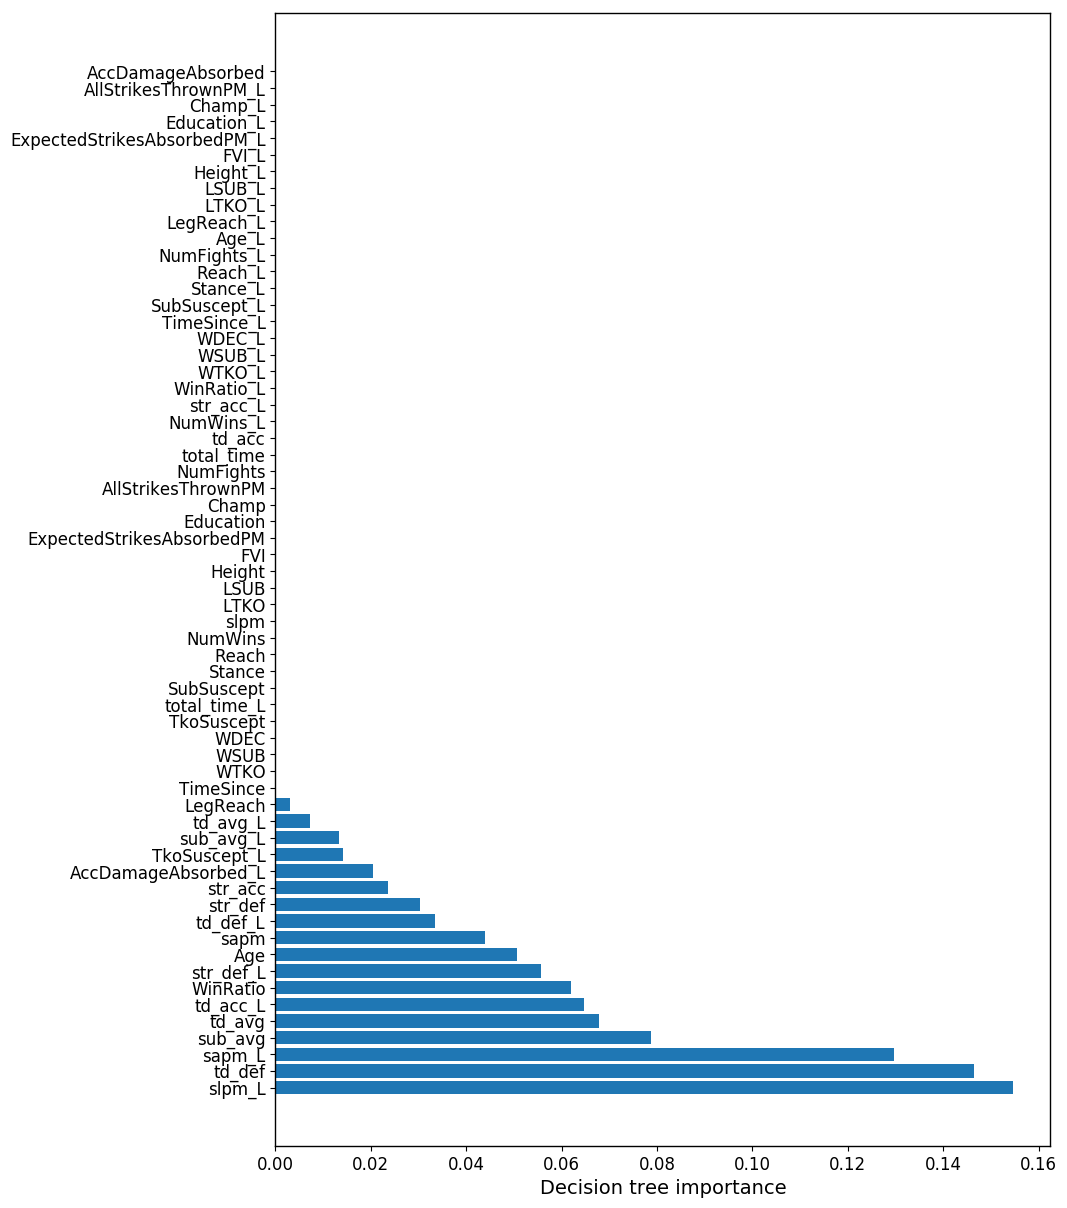

In [108]:
importances = grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 15))
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), gs.columns[indices], rotation=0)
plt.xlabel('Decision tree importance')

Write out the optimal tree to graph file:

In [ ]:
# http://webgraphviz.com (paste contents of file here)
#from sklearn import tree
#fn = ['stance1', 'age1', 'stance2', 'age2']
#cn = ['fighter1 wins', 'fighter2 wins']
#clf.set_params(**grid.best_params_).fit(X_train, y_train)
#tree.export_graphviz(clf, out_file='tree.dot', feature_names=fn, class_names=cn)

In [ ]:
# uncomment below to see log
#grid.cv_results_

### Evaluation of the classifer

In [ ]:
confmat = metrics.confusion_matrix(y_test, y_test_pred)
confmat

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
     for j in range(confmat.shape[1]):
          ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')

### ROC curve

In [ ]:
# store the predicted probabilities for class 1 
y_pred_prob = grid.predict_proba(X_test)[:,1]

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [ ]:
metrics.roc_auc_score(y_test, y_pred_prob)

### Accuracy is maximized at threshold is 1/2 as implied by scoring choice

In [ ]:
thresholds = np.arange(0, 1.05, 0.05)
plt.plot(thresholds, [metrics.accuracy_score(y_test, pd.Series(y_pred_prob).apply(lambda x: 0 if x < threshold else 1)) for threshold in thresholds])

### Precision vs recall

In [ ]:
metrics.recall_score(y_test, y_test_pred)

In [ ]:
metrics.precision_score(y_test, y_test_pred)

In [ ]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_prob, pos_label=1)
plt.plot(recall, precision)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Recall')
plt.ylabel('Precision')

     pre = tp / (tp + fp)
     rec = tp / (tp + fn)
When precision is high we only predict 1 when we are very confident. This means we mostly predict 0 and are frequenty wrong (many FN) which means low recall. When we aggressively predict 1, we have many false positive which drops precision. Recall increases since there are few false negatives.

# Other models

### Neural nets

In [117]:
from sklearn.neural_network import MLPClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(alpha=np.logspace(-4, 0, base=10, num=15))

test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5, 2), random_state=1)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

0 0.633333333333 {'alpha': 0.0013894954943731374} 0.629292929293
1 0.636796536797 {'alpha': 0.0051794746792312128} 0.654545454545
2 0.629437229437 {'alpha': 0.13894954943731375} 0.611111111111
3 0.653246753247 {'alpha': 0.26826957952797248} 0.618181818182
4 0.639393939394 {'alpha': 0.0013894954943731374} 0.616161616162
5 0.654545454545 {'alpha': 1.0} 0.641414141414
6 0.658441558442 {'alpha': 0.13894954943731375} 0.634343434343
7 0.655411255411 {'alpha': 0.00071968567300115217} 0.613131313131
8 0.638528138528 {'alpha': 0.13894954943731375} 0.624242424242
9 0.639826839827 {'alpha': 0.13894954943731375} 0.655555555556


In [118]:
np.array(test_accuracies).mean()

0.6297979797979798

### Random Forest

0 0.65670995671 {} 0.655555555556
1 0.664502164502 {} 0.665656565657
2 0.652380952381 {} 0.635353535354
3 0.652380952381 {} 0.663636363636
4 0.654545454545 {} 0.662626262626
5 0.648917748918 {} 0.668686868687
6 0.650649350649 {} 0.647474747475
7 0.666233766234 {} 0.650505050505
8 0.649350649351 {} 0.653535353535
9 0.6670995671 {} 0.665656565657
0.656868686869 0.639826839827


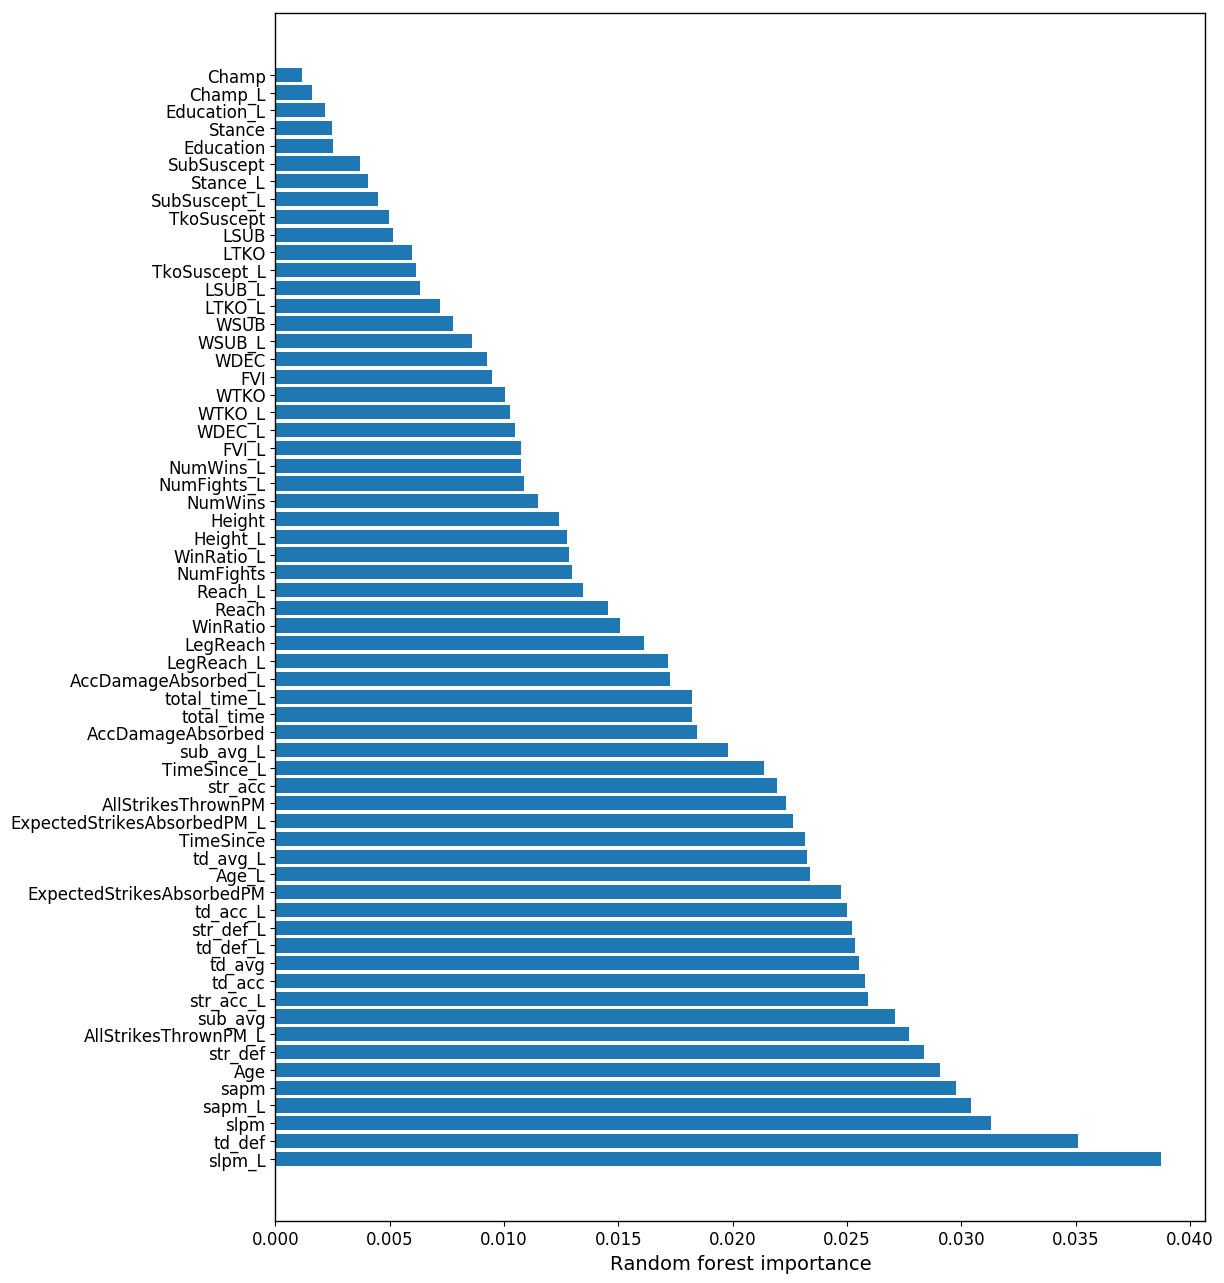

In [115]:
from sklearn.ensemble import RandomForestClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(criterion=['gini', 'entropy'], bootstrap=[True, False])

param_grid = {}

test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', bootstrap=True, oob_score=True)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy
     
print np.array(test_accuracies).mean(), grid.best_estimator_.oob_score_
importances = grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(1, 1, figsize=(12,16))
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), gs.columns[indices], rotation=0)
plt.xlabel('Random forest importance')

In [149]:
jf = pd.read_csv('../../machine_learning/wine.csv')
jf.head()

,1,14.23,1.71,2.43,15.6,127,2.8,3.06,.28,2.29,5.64,1.04,3.92,1065
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [154]:
X_train.shape

(2310, 62)

In [157]:
X = jf.iloc[:,1:].values
y = jf.iloc[:,0].values
X_std = stdsc.fit_transform(X_train)
lda.fit_transform(X_std, y_train)

array([[-0.12977746],
       [ 0.60643449],
       [-1.97003071],
       ..., 
       [ 0.1060077 ],
       [ 0.23947077],
       [ 0.5963186 ]])

### Logistic Regression

In [158]:
from sklearn.linear_model import LogisticRegression

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(C=np.logspace(-4, 1, base=10, num=25), penalty=['l1', 'l2'])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = LogisticRegression()
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     X_std = stdsc.fit_transform(X_train)
     X_std_lda = tsne.fit_transform(X_std, y_train)
     print X_std_lda.shape, X_std.shape
     grid.fit(X_std_lda, y_train)
     # predict test labels
     X_std_lda_test = tsne.transform(stdsc.transform(X_test))
     y_test_pred = grid.predict(X_std_lda_test)
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

(2310, 2) (2310, 62)


AttributeError: 'TSNE' object has no attribute 'transform'

In [136]:
plt.scatter(X_std_lda[y_train==1, 0], X_std_lda[y_train==1, 1])

IndexError: index 1 is out of bounds for axis 1 with size 1

In [137]:
np.array(test_accuracies).mean()

0.66121212121212136

In [ ]:
grid.best_estimator_.coef_

In [ ]:
grid.best_estimator_.intercept_

In [111]:
coeffs = []
c_values = np.logspace(-3, 0, base=10, num=25)
for c in c_values:
     clf = LogisticRegression(C=c, penalty='l1')
     clf.fit(stdsc.fit_transform(X_train), y_train)
     coeffs.append(clf.coef_[0])
cf = pd.DataFrame(coeffs, columns=gs.columns)

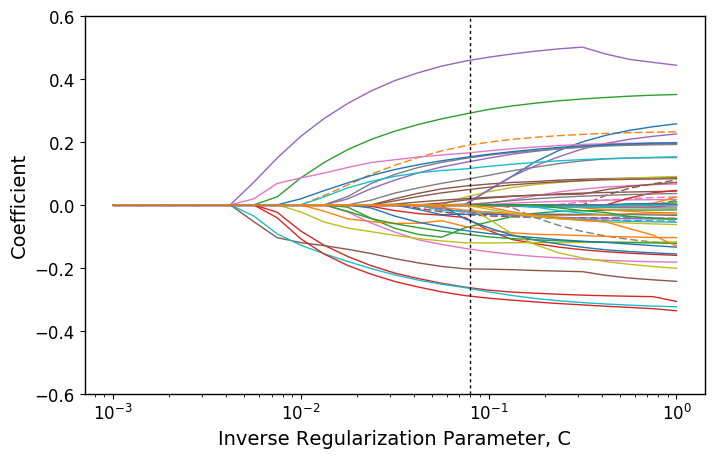

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i in range(cf.shape[1]):
     if (i > 7): plt.semilogx(c_values, cf.iloc[:,i], label=cf.columns[i])
     else: plt.semilogx(c_values, cf.iloc[:,i], label=cf.columns[i], ls='dashed')
plt.axvline(x=0.08, ymin=0, ymax=1, color='k', ls=':')
plt.ylim(-0.6, 0.6)
plt.xlabel('Inverse Regularization Parameter, C')
plt.ylabel('Coefficient')
#plt.legend(loc=(1.05, 0.2))

### AdaBoost

from sklearn.ensemble import AdaBoostClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(learning_rate=np.logspace(-4, 0, base=10, num=5),
                  n_estimators=[25, 50, 100],
                  base_estimator__max_depth=[1, 2, 3])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     tree = DecisionTreeClassifier(criterion='entropy')
     clf = AdaBoostClassifier(tree)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
np.array(test_accuracies).mean()

### KNN

from sklearn.neighbors import KNeighborsClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
# p=2 with minkowski is euclidean so omitted below
param_grid = [dict(n_neighbors=range(10, 110, 10), weights=['uniform', 'distance'],
              metric=['minkowski'], p=[1, 3, 4]),
              dict(n_neighbors=range(10, 110, 10), weights=['uniform', 'distance'],
              metric=['chebyshev', 'euclidean'])]
param_grid = [dict(n_neighbors=range(7, 35, 2), weights=['uniform', 'distance'], metric=['chebyshev', 'euclidean'])]
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = KNeighborsClassifier()
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
np.array(test_accuracies).mean()

### Support Vector Classifier

In [116]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = [dict(kernel=['linear'],
                   C=np.logspace(-3, 3, base=10, num=15),
                   shrinking=[True, False])]
param_grid = [dict(kernel=['linear'], C=np.logspace(-3, 3, base=10, num=7))]
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     clf = SVC(probability=True)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(pca.fit_transform(stdsc.fit_transform(X_train)), y_train)
     # predict test labels
     y_test_pred = grid.predict(pca.transform(stdsc.transform(X_test)))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

KeyboardInterrupt: 

In [ ]:
np.array(test_accuracies).mean()

### Bagged Logistic Regression

#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

X = data.iloc[:,1:].values
y = data.iloc[:,0].values
stdsc = StandardScaler()
StatifiedCV = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = dict(n_estimators=[25, 50],
                  bootstrap_features=[True, False],
                  base_estimator__C=np.logspace(-3, 3, base=10, num=15),
                  base_estimator__penalty=['l1', 'l2'])
test_accuracies = []
for i in range(10):
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
     lr = LogisticRegression()
     clf = BaggingClassifier(base_estimator=lr)
     grid = GridSearchCV(clf, param_grid, cv=StatifiedCV, scoring='accuracy', refit=True)
     grid.fit(stdsc.fit_transform(X_train), y_train)
     # predict test labels
     y_test_pred = grid.predict(stdsc.transform(X_test))
     test_accuracy = metrics.accuracy_score(y_test_pred, y_test)
     test_accuracies.append(test_accuracy)
     print i, grid.best_score_, grid.best_params_, test_accuracy

In [ ]:
np.array(test_accuracies).mean()